Following code aim is:
- to create from a file_name and path a structure of folders where to save all corresponding time series
- to create signal from a parameter list
- to create noise
- to keep records of the parameters used in each signal
- zip the folder

In [ ]:
!pip install pycbc

In [ ]:
import pycbc.waveform as pycbc_wf
import pycbc.psd as pycbc_psd
import pycbc.noise as pycbc_noise
import pycbc.types as pycbcty
import pycbc.detector as pycbc_det
import pycbc.catalog as pycbc_cat
import pycbc.filter as pycbc_fil
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
import shutil as sh
import os as os
import astropy.cosmology as astr_cosm


import warnings
#warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

# Turn interactive plotting off
plt.ioff()

In [ ]:
# the following is to make the process all the way through or instead request for validation before creating train and test images
mode = str(input('Modo Automático de generación de imágenes? [y/n]: '))

if mode == 'y':
    decision = 'y'

Modo Automático de generación de imágenes? [y/n]: n


In the following cell we create the paths and folders required to store the different images: signal and noise, and training and test.

In [ ]:
! rm -r CNN_low_mass/

In [ ]:
# creates paths where to store images and records
file_name = 'CNN_low_mass'

#root_dir = '/home/daniel/Desktop/MSC UCM TEÓRICA/TFM/Codes/TemplateGen/'
root_dir = './'

base_dir = os.path.join(root_dir, file_name)

training_dir = os.path.join(base_dir, 'Training')
test_dir = os.path.join(base_dir, 'Test')

training_signal_dir = os.path.join(training_dir, 'Signal')
training_noise_dir = os.path.join(training_dir, 'Noise')

test_signal_dir = os.path.join(test_dir, 'Signal')
test_noise_dir = os.path.join(test_dir, 'Noise')

# create folder to store everything
os.mkdir(base_dir)

# create folder to store training, and inside create folders to store signal and noise
os.mkdir(training_dir)
os.mkdir(training_noise_dir)
os.mkdir(training_signal_dir)

# create folder to store test, and inside create folders to store signal and noise
os.mkdir(test_dir)
os.mkdir(test_noise_dir)
os.mkdir(test_signal_dir)

Here we first define the frecuency cutoff, minimun frecuency to consider. Then we define the parameters corresponding to training signal images and test signal images. In fact, we expand the parameters hyperspace.

As parameters to generate the GW template we consider $\bf{mass}$, same for both compact objects, $\bf{distance}$ to the source (input to the function is in Mpc) and $\bf{inclination}$, the angle between the angular orbital momentum of the inspiral and the line of sight. All this three are parameters to be considered in the template generator. Later, we 'create' a GW detector where we project the emitted GW onto it to know what wave would these detector measure based on the detector location in Earth and sky location of the source. For that, we consider another parameter: $\bf{RA}$ and $\bf{DEC}$, which will be considered when projecting the wave.

In [ ]:
# low frecuency limit (due to detector sensibility)
cut_off = 30

#############################################################################################################
###############################################  TRAIN PARAMETERS  ##########################################
#############################################################################################################

# source parameters
mass1_tr = [10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
mass2_tr = [11, 13, 15, 17, 19, 21, 23, 25, 27, 29]

#mass1_tr = [10]
#mass2_tr = [11]

distance_red_tr = [0.001, 0.01, 0.05, 0.1, 0.5, 1, 1.5] # in redshift
#distance_red_tr = [0.001] # in redshift
distance_tr = np.array(astr_cosm.Planck15.luminosity_distance(np.array(distance_red_tr))) # convertion to Mpc with Planck18 cosmology

# orbit inclination
inclination_tr = [0, 0.25, 0.5, 1]
#inclination_tr = [0]

# sky location of the source (randomly) --> for the moment 3 locations
ra_tr = np.squeeze(np.random.random(size = (1, 3)) * 2 * np.pi)
dec_tr = np.squeeze(np.random.random(size = (1, 3)) * np.pi)


#############################################################################################################
#############################################################################################################




############################################################################################################
###############################################  TEST PARAMETERS  ##########################################
############################################################################################################

# source paramters
mass1_te = [10, 13, 15, 19, 23, 25, 27]
mass2_te = [11, 13, 16, 20, 22, 26, 29]

#mass1_te = [10]
#mass2_te = [10]

#distance_te = [500] # in Mpc
distance_red_te = [0.001, 0.01, 0.1, 1, 1.5] # in redshift
#distance_red_te = [0.01] # in redshift
distance_te = np.array(astr_cosm.Planck15.luminosity_distance(np.array(distance_red_te))) # convertion to Mpc with Planck18 cosmology

# orbit inclination
inclination_te = [0, 0.5, 0.8, 1]
#inclination_te = [0]

# sky location of the source (randomly) --> for the moment 3 locations
ra_te = np.squeeze(np.random.random(size=(1,3)) * 2 * np.pi)
dec_te = np.squeeze(np.random.random(size=(1,3)) * np.pi)

#############################################################################################################
#############################################################################################################


# define our detector to project GW onto it
Virgo = pycbc_det.Detector('V1')


Here we create a function which when called, it will output a GW generated by two compact black holes of masses "m1" and "m2", emitted from a inspiral with inclination "incl" and a distance "dist".

We use the SEOBNRv4_opt approximant (no precession).

In [ ]:
def template(m1, m2, incl, dist, cut_off):

    """
    Builds a template por a GW merger of both masses 'm' using SEOBNRv4_opt approximation method with a
    sample of 2048 data per second (2048Hz)
    ---------------------------------------------------------------------------------------------------

    Arguments:
    m1 -- mass of the first compact black hole
    m2 -- mass of the second compact black hole
    incl -- angle between angular momentum L and line of sight (from 0 to PI)
    dist -- distance in Mpc to the emitting source
    cut_off -- low frecuency limit

    Return:
    hp, hc -- pycbc.timeseries.TimeSeries, for the plus/cross polarization GW (strain)

    """
    hp, hc = pycbc_wf.get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = m1, mass2 = m2, inclination = incl, distance = dist, delta_t = 1.0 / 2048, f_lower = cut_off)

    return hp, hc

Here we project the previously generated GW form onto our detector to know what waveform would the detector measure based on the relative locations of detector and source. We consider when calling these function the polarizations of the GW wave emitted and sky location of the source.

In [ ]:
def Virgo_gw(hp, hc, ra, dec):

    """
    Project the GW emitted by a source onto the detector to obtain the wave measured by a particular
    detector depending on coordinates of the detector in the Earth and coordinates of the source in the sky
    ------------------------------------------------------------------------------------------------------

    Arguments:
    hp, hc -- pycbc.timeseries-type for the plus/cross polarization GW generated at the source
    ra, dec -- sky location of the source
    pol -- polarization (set to 1)

    Return:
    gw -- pycbc.timeseries.TimeSeries, GW as measured by the detector

    """

    gw = Virgo.project_wave(hp, hc, ra, dec, 1, method = 'lal')

    return gw

Now we compute the background noise of the detector: first we import a Power Spectral Density (PSD) from a detector (these case Advance Virgo) or particular noise sources (seismic, thermic, quantum ...). Then, after setting parameters such as length of the strain or frecuency of the data, we generate the corresponding gaussian noise from the previous PSD. Each time called, a different noise will be created since random seed is not specified.

- *pycbc_psd.analytical.AdvVirgo*: returns a FrequencySeries containing the AdvVirgo PSD from LALSimulation
- *pycbc_noise.gaussian.noise_from_psd*: generates gaussian colored noise — its amplitude depends on frequency exactly as the Virgo PSD.

In [ ]:
# we import NOISE from Virgo detector

delta_t = 1.0 / 2048
time_length = 10 #  seconds of data
length = int(time_length / delta_t) # lenght of the noise strain (I have 10 seconds data and 2048 data each seconds)

# first we import Adv Virgo PSD from LAL Simulations (https://pycbc.org/pycbc/latest/html/pycbc.psd.html)

delta_f = 1.0 / time_length
flength = int(2048 / delta_f)
low_freq_cutoff = cut_off  # corresponding the cutoff of our GW model

AdvV_PSD = pycbc_psd.analytical.AdvVirgo(flength, delta_f, low_freq_cutoff)

# from our simulated PSD now we obtain our gausian noise (https://pycbc.org/pycbc/latest/html/pycbc.noise.html#module-pycbc.noise.gaussian)

In [ ]:
def noise_gen(length, delta_t, PSD):

    """
    From a previous simulated PSD it generates gaussian noise
    ---------------------------------------------------------

    Arguments:
    length -- length of the array of noise
    delta_t -- time in sec between two consecutive data
    PSD -- Power Spectral Density of the desired noise

    Return:
    strain_noise -- noise generated from PSD

    """

    strain_noise = pycbc_noise.gaussian.noise_from_psd(length, delta_t, PSD, seed = None)

    return strain_noise

In this cell we build the injection function: from an input signal waveform measured by the detector and a background noise, the function will inject the signal into the noise, forming what a detector would measure: a strain data formed by noise and a candidate signal to GW.

The injection is done randomly, without previously setting the time point when to inject the signal in the noise. However, the injectiong point is saved to keep a record.

The order of magnitude of the simulated GW signal and the noise are not in real scale. Maybe GW signal is   ~1e-18 while noise is ~1e-21, which is an unreal situation. Therefore the injected GW is rescaled (this can be the weakest point in the whole code).

*UPDATE (16-03-2023)*: now we will rescale the GW signal inside the noise according to a desired SNR. In the following, we will introduce a scaling factor "scale", and afterwards we will calculate the resulting SNR. However, we previously have done a study on how scaling modifies SNR

- SNR $\sim$ 15 $\rightarrow$ scale x 2
- SNR $\sim$ 4-6 $\rightarrow$ scale x (0 , 0.75)

We can define our scale factor according to the desired SNR. If we want sensitivity in SNR=4-10 detections, then we might fix scale factor to a random number in a normal distribution centered in scale factor for 0.4 with deviation up to scale factor for SNR=10

*UPDATE (18-03-2023)*: this actually doesnt work. SNR varies also with distance and therefore we would need to adjust scale factor according to desired SNR and distance and masses... too many parameters to adjust SNR.

We will simply inject the signal and then calculate resulting SNR.

In [ ]:
from __future__ import with_statement
from scipy.signal.windows import tukey

def injection_by_hand(strain, signal):

    """
    This is an injection "by hand", injecting a signal inside a strain of noise
    ---------------------------------------------------------------------------

    Arguments:
    strain -- noise or ground data
    signal -- simulated GW signal to inject inside de strain

    Returns:
    data -- noise + signal strain
    smooth -- noise + signal strain whitened
    sig_loc -- location where the merger is inside de strain

    """

    if len(strain) <= len(signal):
        raise ValueError('Strain data length should be bigger than signal data')
    if strain.delta_t != signal.delta_t:
        raise ValueError('Strain and signal must contain same delta_t')

    # strain and noise frec 2048 Hz
    len_signal = len(signal) # length of the signal
    len_strain = len(strain) # length of the noise
    dif = len_strain - len_signal

    # for a random place inside de strain we will introduce the signal. This place should be such that the signal
    # length can fit inside

    # compute starting time to inject signal by injecting it in a randomly position
    loc = np.random.randint(2*2048, dif-2048*2)

    h = strain.copy()

    # inject the signal, and multiply by a rescaling factor --> this way the signal isn't too big to be unreal
    # but not too small to be undetected by the Q transform

    scale = np.mean(abs(np.array(strain))) / np.mean(abs(np.array(signal)))
    # non physical value
    scale=0.01

    h[loc:loc+len_signal] = strain[loc:loc+len_signal] + np.asarray(signal) * scale # rumore + segnale * scale

    sig_loc = (loc + np.argmax(np.array(signal))) * strain.delta_t

    data = pycbcty.timeseries.TimeSeries(h, strain.delta_t)

    '''
    # apply a Tukey window
    window = tukey(20480)
    data = data * window

    # whiten the data
    fdata = data.to_frequencyseries()
    psd = pycbc_psd.analytical.AdvVirgo(len(fdata), delta_f, cut_off)
    psd = np.array(psd)
    psd[psd==0]=1
    white_data = (fdata / (psd ** 0.5)).to_timeseries()
    '''

    white_data = data.copy()
    white_data = white_data.whiten(4, 2, low_frequency_cutoff=30.0)

    # bandpass
    smooth = pycbc_fil.resample.highpass_fir(white_data, 30, 8)
    smooth = pycbc_fil.resample.lowpass_fir(smooth, 200, 8)

    return data, smooth, sig_loc

Let's plot an example of the preprocessing applied to the strain data

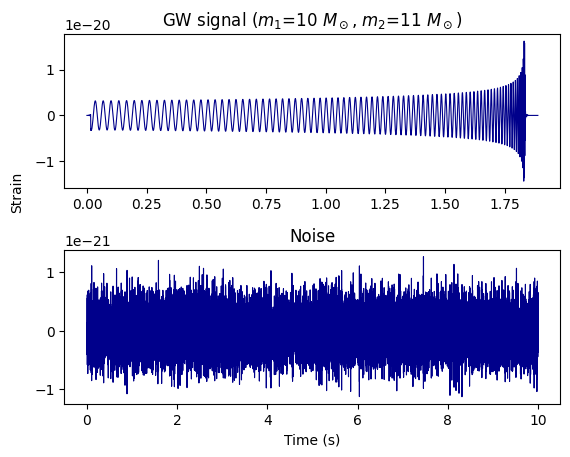

In [ ]:
m1 = mass1_tr[0]
m2 = mass2_tr[0]
incl = inclination_tr[0]
dist = distance_tr[0]
ra = ra_tr[0]
dec = dec_tr[0]

hp, hc = template(m1, m2, incl, dist, cut_off)
signal = Virgo_gw(hp, hc, ra, dec)
noise = noise_gen(length, delta_t, AdvV_PSD)

fig, axs = plt.subplots(2)

axs[0].set_title(fr'GW signal ($m_1$={m1} $M_\odot$, $m_2$={m2} $M_\odot$)')
signal_times = np.array(signal.sample_times) + abs(min(np.array(signal.sample_times)))
axs[0].plot(signal_times, signal, c='darkblue', linewidth=0.8)

axs[1].set_title('Noise')
axs[1].plot(noise.sample_times, noise, c='darkblue', linewidth=0.8)

fig.text(0.04, 0.55, 'Strain', va='center', rotation='vertical')
plt.xlabel('Time (s)')

plt.subplots_adjust(hspace=0.4)
plt.show()
plt.close()

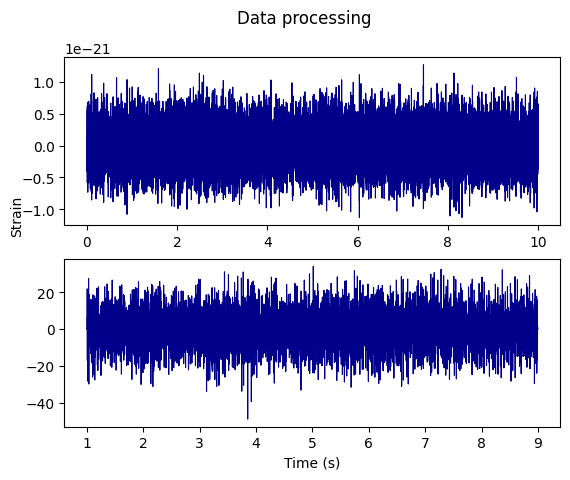

In [ ]:
data, whiten_data, _ = injection_by_hand(noise, signal)

fig, axs = plt.subplots(2)
fig.suptitle('Data processing')
axs[0].plot(data.sample_times, data, c='darkblue', linewidth=0.8)
axs[1].plot(whiten_data.sample_times, whiten_data, c='darkblue', linewidth=0.8)

fig.text(0.04, 0.55, 'Strain', va='center', rotation='vertical')
plt.xlabel('Time (s)')
plt.show()
plt.close()

We now define a function which will compute the SNR ratio.

In [ ]:
def SNR(model, noise):
    """
    Computes the Signal-to-Noise Ratio for a given data expressed as sum of a noise and model

    Arguments:
    model -- GW template
    noise -- background noise in the detector


    Return:
    SNR -- Signal to Noise ratio
    """

    candidate, _, _ = injection_by_hand(noise, model)

    model_copy = model.copy()
    model_copy.resize(len(candidate))

    snr = pycbc_fil.matchedfilter.matched_filter(model_copy, candidate, psd=AdvV_PSD, low_frequency_cutoff=30.0)
    return snr

SNR: 7.812840152768126


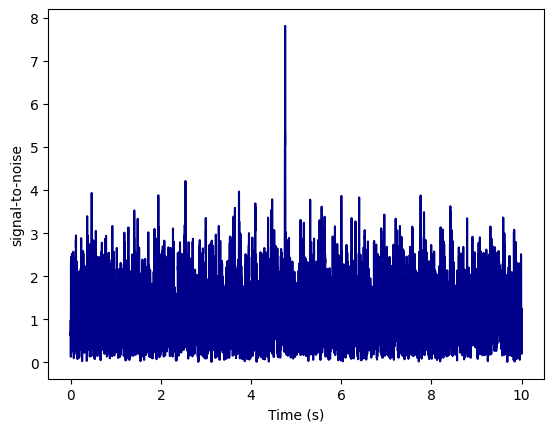

In [ ]:
snr = SNR(signal, noise)
print('SNR:', max(abs(snr)))

plt.plot(snr.sample_times, abs(snr), color='darkblue')
plt.ylabel('signal-to-noise')
plt.xlabel('Time (s)')
plt.show()

The following function call for all previous functions to create a bank of images: by specifying the corresponding parameters and its purpose (train or test), the code will run the required functions to generate a signal, a background noise, inject it, save the records of the injection time and parameters used and save in the corresponding folder if train or test.

In [ ]:
import h5py
def bank_generator(mass1, mass2, inclination, distance, ra, dec, purpose):

    """
    Computes all images for a parameter space
    -----------------------------------------

    Arguments:
    mass1 mass2 -- masses of both compact black holes
    inclination -- angle between angular momentum L and line of sight (from 0 to PI)
    distance -- distance in Mpc to the emitting source
    ra dec -- sky location of the source
    purpose -- 'train' or 'test'

    Return:
    timeseries in .csv format
    record file in .csv format

    """
    # starts the records file
    file = ['Ref.Name',  'Mass 1', 'Mass 2', 'SNR', 'Distance(Mpc)',  'Inclination (pi units)',  'MergerTime(sec)',  'Ra',  'Dec']

    # according to the purpose (train or test) we specificy the path to save the images
    if purpose == 'train':
        dir_name = training_signal_dir

    elif purpose == 'test':
        dir_name = test_signal_dir

    else:
        raise ValueError('Purpose must be train or test')

    for M1 in tqdm(mass1):

        for M2 in (mass2):

            it = 1 # keep the record of number of sample inside a collection of images for mass M

            for inc in inclination:
                for di in distance:
                    for i in range(len(ra)):

                        hp, hc = template(M1, M2, inc * np.pi, di, cut_off) # GW wave emitted by source
                        strain = noise_gen(length, delta_t, AdvV_PSD) # noise simulated from detector


                        gw_signal = Virgo_gw(hp, hc, ra[i], dec[i]) # GW projection as measured by detector

                        # we select a scale factor in a normal distribution with average SNR=4-6

                        _, candidate, sig_loc = injection_by_hand(strain, gw_signal) # injection of the measured GW waveform

                        snr = SNR(gw_signal, strain)
                        snr_value = max(abs(snr))

                        dic = {'mass 1':M1, 'mass2':M2, 'SNR':snr_value, 'distance (Mpc)':di, 'inclination':inc, 'merger time (sec)':sig_loc, 'ra':ra[i], 'dec':dec[i]}

                        ###################################################################
                        ref_name = f'mass1-{M1}_mass2-{M2}_sample{it}'
                        h5_path = f'{dir_name}/{ref_name}.h5'

                        with h5py.File(h5_path, 'w') as f:
                            f.create_dataset('strain', data=candidate.data)
                            f.create_dataset('time', data=candidate.sample_times.data)

                        #####################################################################
                        file_aux = []
                        file_aux.append('mass1-{}_mass2-{}_sample{}'.format(M1, M2, it))
                        for j in dic.values():
                            file_aux.append(j)
                        file = np.vstack((file,file_aux))
                        #####################################################################


                        it += 1

    return file

The former function was used to create signal images. This one is used to create noise images. Just calls the noise generator and specifies the save folder through the purpose specification.

In [ ]:
def just_noise(N, purpose):

    """
    This function generates N timeseries of noise
    ---------------------------------------------------------------

    Arguments:
    N -- number of images generated
    purpose -- train or test

    Return:
    images -- .png or similar format images

    """

    # again we specify the path to save images
    if purpose == 'train':
        dir_name = training_noise_dir

    elif purpose == 'test':
        dir_name = test_noise_dir

    else:
        raise ValueError('Purpose must be train or test')

    it = 1 # keeps the count for the number of samples
    for i in tqdm(range(N)):
        strain = noise_gen(length, delta_t, AdvV_PSD) # noise simulated from detector

        strain = strain.whiten(4, 2, low_frequency_cutoff=30.0)

        # bandpass
        smooth = pycbc_fil.resample.highpass_fir(strain, 30, 8)
        smooth = pycbc_fil.resample.lowpass_fir(smooth, 200, 8)

        ref_name = f'noise_sample{it}'
        h5_path = f'{dir_name}/{ref_name}.h5'

        with h5py.File(h5_path, 'w') as f:
          f.create_dataset('strain', data=smooth.data)
          f.create_dataset('time', data=smooth.sample_times.data)

        it += 1

    return

In [ ]:
! rm -r CNN_run_1/

Following cells calls for all previous functions to create the images and save them in the corresponding folders. First we created the training images by calling bank_generator function to create signal images and then just_noise to create noise images. All this by using the training parameters defined at the very first lines of code. After creating all images, it creates a .csv file containing the records for signal images, including its parameters and injection time.

Same for test images.

Before creating them, the code will print a validation statement where prints number of images to create and a required confirmation to go ahead with the process. Both validations for training and test sets are required.

In [ ]:
# cell to run code for template bank generator. Need to confirm.
####################################################################################################################
#################################################  TRAIN  ##########################################################
####################################################################################################################


num = len(inclination_tr) * len(distance_tr) * len(ra_tr) * len(mass1_tr) * len(mass2_tr) # number of images
print('Se generarán ',num,' TRAINING imágenes de señal GW. También se generará el mismo número de imágenes de ruido.')
if mode == 'n':
    decision = str(input('Quieres seguir con el proceso? [y/n]: '))

if decision == 'y':
    rec = bank_generator(mass1_tr, mass2_tr, inclination_tr, distance_tr, ra_tr, dec_tr, purpose='train')
    df = pd.DataFrame(rec)
    df.columns = ['Ref.Name',  'Mass 1', 'Mass 2', 'SNR', 'Distance(Mpc)',  'Inclination (pi units)',  'MergerTime(sec)',  'Ra',  'Dec']
    df.to_csv(training_dir + '/Records_training_signal.csv', sep='\t', float_format='%.4f', header=False, index=False)

    just_noise(num, purpose = 'train')


elif decision == 'n':
    print('Proccess aborted')



####################################################################################################################
#################################################  TEST  ###########################################################
####################################################################################################################

num = len(inclination_te) * len(distance_te) * len(ra_te) * len(mass1_te) * len(mass2_te) # number of images
print('Se generarán ',num,' TEST imágenes de señal GW. También se generará el mismo número de imágenes de ruido.')

if mode == 'n':
    decision = str(input('Quieres seguir con el proceso? [y/n]: '))

if decision == 'y':
    rec = bank_generator(mass1_te, mass2_te, inclination_te, distance_te, ra_te, dec_te, purpose='test')
    df = pd.DataFrame(rec)
    df.columns = ['Ref.Name',  'Mass 1', 'Mass 2', 'SNR', 'Distance(Mpc)',  'Inclination (pi units)',  'MergerTime(sec)',  'Ra',  'Dec']
    df.to_csv(test_dir + '/Records_test_signal.csv', sep='\t', float_format='%.4f', header=False, index=False)

    just_noise(num, purpose = 'test')


elif decision == 'n':
    print('Proccess aborted')

Se generarán  8400  TRAINING imágenes de señal GW. También se generará el mismo número de imágenes de ruido.
Quieres seguir con el proceso? [y/n]: y


 20%|██        | 2/10 [28:46<1:55:29, 866.16s/it]

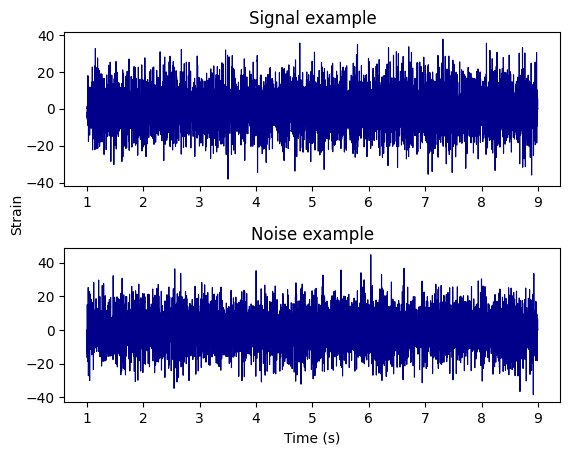

In [ ]:
signal_name = 'mass1-10_mass2-11_sample1.h5'
noise_name = 'noise_sample1.h5'

with h5py.File(os.path.join(training_signal_dir, signal_name), 'r') as f:
    time_signal = f['time'][:]
    strain_signal = f['strain'][:]

with h5py.File(os.path.join(training_noise_dir, noise_name), 'r') as f:
    time_noise = f['time'][:]
    strain_noise = f['strain'][:]

fig, axs = plt.subplots(2)

axs[0].set_title('Signal example')
axs[0].plot(time_signal, strain_signal, c='darkblue', linewidth=0.8)

axs[1].set_title('Noise example')
axs[1].plot(time_noise, strain_noise, c='darkblue', linewidth=0.8)

fig.text(0.04, 0.50, 'Strain', va='center', rotation='vertical')
plt.xlabel('Time (s)')

plt.subplots_adjust(hspace=0.4)
plt.show()
plt.close()

To end the code, we compress the folder containing all subfolders and images in a .zip file and remove the original folder (not zip) to avoid duplicates.

In [ ]:
# creates a zip file containin all images and records, and them removes the directory where images where originally stored, to avoid duplicates
sh.make_archive(base_dir,'zip',root_dir,file_name)
sh.rmtree(base_dir)

Enlaces de interés:

https://lscsoft.docs.ligo.org/lalsuite/lalsimulation/group___l_a_l_sim_noise_p_s_d__c.html

http://pycbc.org/pycbc/latest/html/pycbc.psd.html

http://pycbc.org/pycbc/latest/html/pycbc.noise.html

http://pycbc.org/pycbc/latest/html/pycbc.html#pycbc.detector.Detector

http://pycbc.org/pycbc/latest/html/pycbc.waveform.html#pycbc.waveform.waveform.get_td_waveform

https://lscsoft.docs.ligo.org/lalsuite/lalsimulation/group___l_a_l_sim_noise_p_s_d__c.html
